在本附录中，将更深入地介绍NumPy库的矩阵计算。内容将包括更多的ndarray内部细节和更多高级数组操作和算法。

本附录包含多个主题，无须按顺序阅读。

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

## A.1　ndarray对象内幕
NumPy的ndarray提供了一种方法将一组同构数据（连续的或跨步的）解释为多维数组对象。数据类型或dtype决定数据如何被解释为浮点数、整数、布尔值或正在查看的任何其他类型。

让ndarray如此灵活的部分原因是每个数组对象都是一个数据块的分步视图。例如，可能会想知道数组视图`arr[：：2, ：：-1]`如何做到不复制任何数据。原因是ndarray不仅仅是一块内存和一个dtype，它还具有“跨步”信息，使数组能够以不同的步长在内存中移动。更准确地说，ndarray内部包含以下内容：

* 指向数据的指针——即RAM中或内存映射文件中的数据块

* 数据类型或dtype，描述数组中固定大小的值单元格

* 表示数组形状(shape)的元组

* 步长元组(stride)，表示要“步进”的字节数的整数以便沿维度推进一个元素

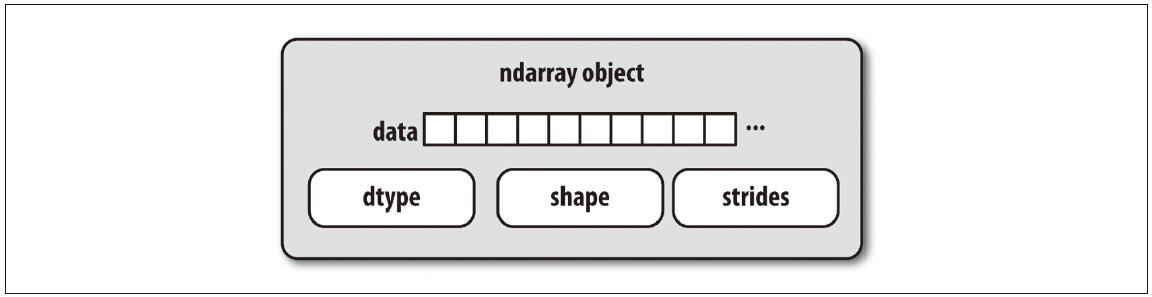

例如，一个10×5的数组，其shape为(10，5)：

In [2]:
np.ones((10, 5)).shape

(10, 5)

一个典型的（C阶）3×4×5float64值（8字节）的数组具有跨度（160，40，8）（了解跨度可能是有用的，因为通常特定轴上的跨度越大，沿着该轴执行计算的代价越高）：

In [3]:
print(np.ones((3, 4, 5), dtype=np.float64).shape)
# 一个float64类型占用8位地址，5*8=40，40*4=160
print(np.ones((3, 4, 5), dtype=np.float64).strides)

(3, 4, 5)
(160, 40, 8)


虽然一般的NumPy用户很少会对数组跨度（strides）感兴趣，但它们是构建“零复制”数组视图的关键因素。跨度甚至可以是负的，这使得数组能够穿过内存“向后”移动（例如，在诸如obj[：：-1]或obj[：，：：-1]的切片中就是这种情况）。

### A.1.1　NumPy dtype层次结构
可能时不时会需要写代码检查数组是否包含整数、浮点数、字符串或Python对象。由于浮点数有多种类型（float16到float128），因此检查dtype是否在类型列表中会非常麻烦。幸运的是，dtype有超类，如np.integer和np.floating，它们可以和np.issubdtype函数一起使用：

In [4]:
ints = np.ones(10, dtype=np.uint16)

floats = np.ones(10, dtype=np.float32)

np.issubdtype(ints.dtype, np.integer)

True

In [5]:
np.issubdtype(floats.dtype, np.floating)

True

可以通过调用类型的`mro`方法来查看特定dtype的所有父类：

In [6]:
np.float64.mro()

[numpy.float64,
 numpy.floating,
 numpy.inexact,
 numpy.number,
 numpy.generic,
 float,
 object]

因此，可以得到：

In [7]:
np.issubdtype(ints.dtype, np.number)

True

大部分NumPy用户不必知道这点，但知道了就偶尔可以派上用场。下图是dtype的层次结构父类-子类关系图。

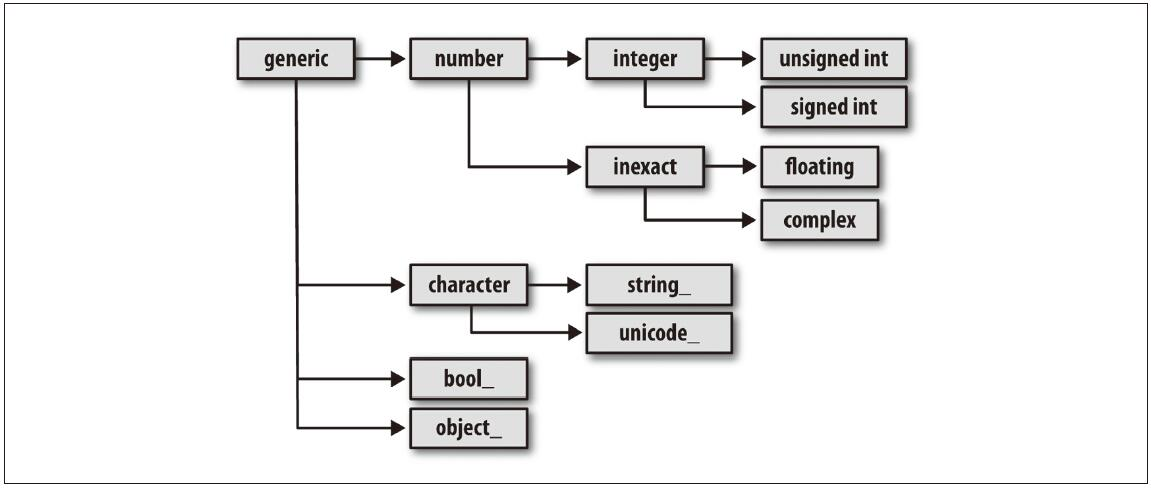

## A.2　高阶数组操作
除了神奇索引、切片和布尔值子集外，还有很多方式可以处理数组。虽然大部分数据分析应用程序的繁重工作都是由pandas中的高级函数处理的，但有时候你可能需要编写一些在现有库中找不到的数据算法。

### A.2.1　重塑数组
在很多情况下，将数组从一个形状转换为另一个形状，并且不复制任何数据。为了实现这个功能，可以向`reshape`数组实例方法传递一个表示新形状的元组。例如，假设有一个一维数组，想要把该数组重新排列进一个矩阵：

In [8]:
arr = np.arange(8)

arr

array([0, 1, 2, 3, 4, 5, 6, 7])

In [9]:
arr.reshape((4, 2))

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

多维数组也可以被重塑：

In [10]:
arr.reshape((4, 2)).reshape((2, 4))

array([[0, 1, 2, 3],
       [4, 5, 6, 7]])

传递的形状维度可以有一个值是-1，表示维度通过数据进行推断：

In [11]:
arr = np.arange(15)

arr.reshape((5, -1))

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

由于数组的shape属性是一个元组，它也可以被传递给reshape：

In [12]:
other_arr = np.ones((3, 5))

other_arr.shape

(3, 5)

In [13]:
arr.reshape(other_arr.shape)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

`reshape`的反操作可以将更高维度的数组转换为一维数组，这种操作通常被成为扁平化（flattening）或分散化（raveling）：

In [14]:
arr = np.arange(15).reshape((5, 3))

arr

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

In [15]:
arr.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

如果结果中的值在原始数组中是连续的，则ravel不会生成底层数值的副本。`flatten`方法的行为类似于`ravel`，但它总是返回数据的副本：

In [16]:
arr.flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

数据可以按照不同的顺序进行重塑或扁平化。顺序对于新的NumPy用户来说，这是一个有点微妙的主题，因此是下一个子主题。

### A.2.2　C顺序和Fortran顺序
NumPy提供内存中数据布局的控制和灵活性。默认情况下，NumPy数组是按行方向顺序创建的。在空间上，这意味着如果有一个二维的数据数组，数组每行中的元素存储在相邻的存储单元中。行方向顺序的替代方法是列方向顺序，这意味着每列数据中的值都存储在相邻的内存位置中。

由于历史原因，行和列方向的顺序也分别称为C顺序和Fortran顺序。在FORTRAN 77语言中，矩阵都是列方向的。

像`reshape`和`ravel`函数接收一个`order`参数，该参数表示数据在数组中使用哪种顺序。在大部分情况下，该参数可以被设置为'C'或'F'（还有一些不太常用的选项'A'和'K'。请参考NumPy官方文档。

In [17]:
arr = np.arange(12).reshape((3, 4))

arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [18]:
arr.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [19]:
arr.ravel('F')

array([ 0,  4,  8,  1,  5,  9,  2,  6, 10,  3,  7, 11])

对二维以上的数组重塑可能会有点令人费解。C顺序和Fortran顺序的核心区别就是在维度方向上遍历的方式：

C顺序/行方向顺序：首先遍历更高的维度（例如，在轴0上行进之前先在轴1上行进）

Fortran顺序/列方向顺序：最后遍历更高的维度（例如，在轴1上行进之前先在轴0上行进）

### A.2.3　连接和分隔数组
`numpy.concatenate`可以获取数组的序列（元组、列表等），并沿着输入轴将它们按顺序连接在一起：

In [20]:
arr1 = np.array([[1, 2, 3], [4, 5, 6]])

arr2 = np.array([[7, 8, 9], [10, 11, 12]])

np.concatenate([arr1, arr2], axis=0)

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [21]:
np.concatenate([arr1, arr2], axis=1)

array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]])

对于常见的连接类型有一些方便的函数，比如`vstack`和`hstack`。之前的操作可以这样表达：

In [22]:
np.vstack((arr1, arr2))

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [23]:
np.hstack((arr1, arr2))

array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]])

另一方面，`split`可以将一个数组沿轴向切片成多个数组：

In [24]:
arr = np.arange(10).reshape((5,2), order='F')

arr

array([[0, 5],
       [1, 6],
       [2, 7],
       [3, 8],
       [4, 9]])

In [25]:
first, second, third = np.split(arr, [1, 3])

first

array([[0, 5]])

In [26]:
second

array([[1, 6],
       [2, 7]])

In [27]:
third

array([[3, 8],
       [4, 9]])

> 传递给`np.split`的值`[1, 3]`表示将数组拆分时的索引位置。

下表是全部有关连接和分隔的函数列表，其中一些仅作为通用`concatenate`的便捷方法。

| 函数 | 描述 |
| ---- | ---- |
| concatenate | 最通用的函数,沿一个轴向连接数组的集合 |
| vstack, row_stack | 按行堆叠数组(沿着轴0) |
| hstack | 按列堆叠数组(沿着轴1) |
| column_stack | 类似于 hstack,但会首先把1维数组转换为2维列向量 |
| dstack | 按“深度”堆叠数组(沿着轴2) |
| split | 沿着指定的轴,在传递的位置上分隔数组 |
| hsplit/vsplit | 分别是沿着轴0和轴1进行分隔的方便函数 |

#### A.2.3.1　堆叠助手：`r_`和`c_`

在NumPy命名空间中有两个特殊的对象：`r_`和`c_`，它们可以使堆栈数组的操作更为简洁：

In [28]:
arr = np.arange(6)

arr1 = arr.reshape((3, 2))

arr2 = np.random.randn(3, 2)

np.r_[arr1, arr2]

array([[ 0.        ,  1.        ],
       [ 2.        ,  3.        ],
       [ 4.        ,  5.        ],
       [-0.13132617,  1.62516341],
       [-0.51834478, -0.4707204 ],
       [-2.25428933, -1.9954431 ]])

In [29]:
np.c_[np.r_[arr1, arr2], arr]

array([[ 0.        ,  1.        ,  0.        ],
       [ 2.        ,  3.        ,  1.        ],
       [ 4.        ,  5.        ,  2.        ],
       [-0.13132617,  1.62516341,  3.        ],
       [-0.51834478, -0.4707204 ,  4.        ],
       [-2.25428933, -1.9954431 ,  5.        ]])

这些函数还可以将切片转换为数组：

In [30]:
np.c_[1:6, -10:-5]

array([[  1, -10],
       [  2,  -9],
       [  3,  -8],
       [  4,  -7],
       [  5,  -6]])

### A.2.4　重复元素：tile和repeat
`repeat`和`tile`函数是用于重复或复制数组的两个有用的工具。`repeat`函数按照给定次数对数组中的每个元素进行复制，生成一个更大的数组：

In [31]:
arr = np.arange(3)

arr

array([0, 1, 2])

In [32]:
# 按元素堆叠
arr.repeat(2)

array([0, 0, 1, 1, 2, 2])

> 对于NumPy而言，复制或重复数组的需求可能不如其他数组编程框架（如MATLAB）那样常见。其中一个原因是广播通常会更好地满足这一需求，这是下一部分的主题。

默认情况下，如果传递一个整数，每个元素都会复制相应的次数。如果传递了一个整数数组，每个元素都会重复相应的不同次数：

In [33]:
arr.repeat([2, 3, 4])

array([0, 0, 1, 1, 1, 2, 2, 2, 2])

多维数组可以在指定的轴向上对它们的元素进行重复：

In [34]:
arr = np.random.randn(2, 2)

arr

array([[ 0.9477526 , -0.06034645],
       [ 0.46621987, -0.85140796]])

In [35]:
print(arr.repeat(2, axis=1), '\n')
print(arr.repeat(2, axis=0), '\n')
print(arr.repeat(2))

[[ 0.9477526   0.9477526  -0.06034645 -0.06034645]
 [ 0.46621987  0.46621987 -0.85140796 -0.85140796]] 

[[ 0.9477526  -0.06034645]
 [ 0.9477526  -0.06034645]
 [ 0.46621987 -0.85140796]
 [ 0.46621987 -0.85140796]] 

[ 0.9477526   0.9477526  -0.06034645 -0.06034645  0.46621987  0.46621987
 -0.85140796 -0.85140796]


> 如果没有传递轴，数组将首先扁平化。

同样，需要按照不同次数重复多维数组的切片时，可以传递一个整数数组：

In [36]:
arr.repeat([2, 3], axis=0)

array([[ 0.9477526 , -0.06034645],
       [ 0.9477526 , -0.06034645],
       [ 0.46621987, -0.85140796],
       [ 0.46621987, -0.85140796],
       [ 0.46621987, -0.85140796]])

In [37]:
arr.repeat([2, 3], axis=1)

array([[ 0.9477526 ,  0.9477526 , -0.06034645, -0.06034645, -0.06034645],
       [ 0.46621987,  0.46621987, -0.85140796, -0.85140796, -0.85140796]])

另一方面，`tile`是一种快捷方法，它可以沿着轴向堆叠副本。在视觉上，可以把它看作类似于“铺设瓷砖”：

In [38]:
arr

array([[ 0.9477526 , -0.06034645],
       [ 0.46621987, -0.85140796]])

In [39]:
# 按块堆叠
np.tile(arr, 2)

array([[ 0.9477526 , -0.06034645,  0.9477526 , -0.06034645],
       [ 0.46621987, -0.85140796,  0.46621987, -0.85140796]])

第二个参数是瓷砖的数量。用标量来说，铺设是逐行进行的，而不是逐列。`tile`的第二个参数可以是表示“铺瓷砖”布局的元组：

In [40]:
arr

array([[ 0.9477526 , -0.06034645],
       [ 0.46621987, -0.85140796]])

In [41]:
np.tile(arr, (2, 1))

array([[ 0.9477526 , -0.06034645],
       [ 0.46621987, -0.85140796],
       [ 0.9477526 , -0.06034645],
       [ 0.46621987, -0.85140796]])

In [42]:
np.tile(arr, (3, 2))

array([[ 0.9477526 , -0.06034645,  0.9477526 , -0.06034645],
       [ 0.46621987, -0.85140796,  0.46621987, -0.85140796],
       [ 0.9477526 , -0.06034645,  0.9477526 , -0.06034645],
       [ 0.46621987, -0.85140796,  0.46621987, -0.85140796],
       [ 0.9477526 , -0.06034645,  0.9477526 , -0.06034645],
       [ 0.46621987, -0.85140796,  0.46621987, -0.85140796]])

### A.2.5　神奇索引的等价方法：take和put
使用整数数组通过神奇索引是获取、设置数组子集的一种方式：

In [43]:
arr = np.arange(10) * 100
arr

array([  0, 100, 200, 300, 400, 500, 600, 700, 800, 900])

In [44]:
# 位置索引
inds = [7, 1, 2, 6]

arr[inds]

array([700, 100, 200, 600])

还有其他一些ndarray方法可以用于特殊情况下在单个轴上的数据选取：

In [45]:
# 取位置
arr.take(inds)

array([700, 100, 200, 600])

In [46]:
# 置入对应位置
arr.put(inds, 42)

arr

array([  0,  42,  42, 300, 400, 500,  42,  42, 800, 900])

In [47]:
arr.put(inds, [40, 41, 42, 43])

arr

array([  0,  41,  42, 300, 400, 500,  43,  40, 800, 900])

如果要在别的轴上使用`take`，可以传递`axis`关键字：

In [48]:
inds = [2, 0, 2, 1]

# arr = np.random.randn(2, 4)
arr = np.arange(16).reshape((4,4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [49]:
arr.take(inds, axis=1)

array([[ 2,  0,  2,  1],
       [ 6,  4,  6,  5],
       [10,  8, 10,  9],
       [14, 12, 14, 13]])

`put`不接受`axis`参数，而是将数组索引到扁平版本（一维，C顺序）。因此，当需要使用其他轴上的索引数组设置元素时，通常最容易使用神奇索引。

## A.3　广播
广播描述了算法如何在不同形状的数组之间进行运算。它是一个强大的功能，但可能会导致混淆，即使对于有经验的用户也是如此。最简单的广播示例发生在将标量值与数组组合的时候：

In [50]:
arr = np.arange(5)

arr

array([0, 1, 2, 3, 4])

In [51]:
pow(arr,3)

array([ 0,  1,  8, 27, 64])

这里“标量值4已经被广播给乘法运算中的所有其他元素”。


可以通过减去列均值来降低数组中的每一列的数值。在这种情况下，它非常简单：

In [52]:
# arr = np.random.randn(4, 3)
arr = np.arange(12).reshape((4,3), order='C')

arr.mean(axis=0)

array([4.5, 5.5, 6.5])

In [53]:
demeaned = arr - arr.mean(0)

demeaned

array([[-4.5, -4.5, -4.5],
       [-1.5, -1.5, -1.5],
       [ 1.5,  1.5,  1.5],
       [ 4.5,  4.5,  4.5]])

In [54]:
demeaned.mean(0)

array([0., 0., 0.])

对行进行减均值的广播需要更小心。幸运的是，只要遵循规则，就可以在数组的任何维度上对潜在较低维度值进行广播（例如从二维数组的每一列中减去行均值）。

于是有广播的规则

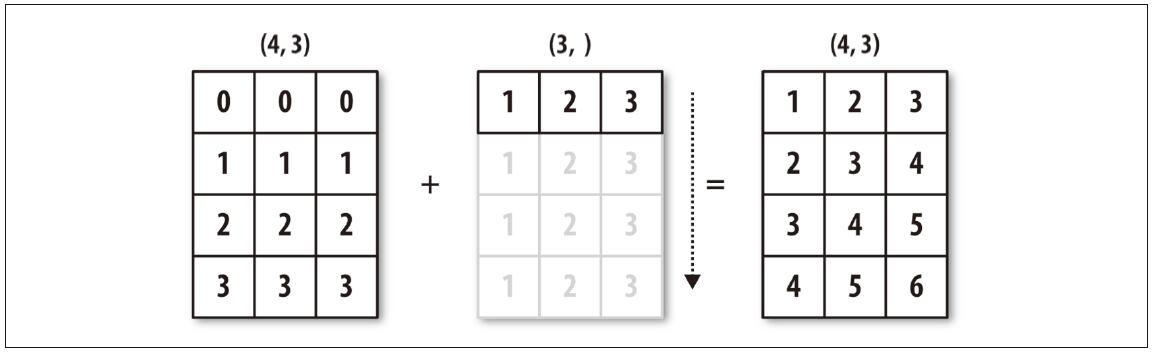

如果对于每个结尾维度（即从尾部开始的），轴长度都匹配或者长度都是1，两个二维数组就是可以兼容广播的。之后，广播会在丢失的或长度为1的轴上进行。

即使是个经验丰富的NumPy用户，但也不得不经常在思考广播机制时，停下来画一张图。考虑上一个例子，假设希望减去每一行的平均值。由于arr.mean(0)的长度为3，因此它与轴0上的广播兼容，因为arr中的结尾维度为3，因此匹配。

根据规则，为了从轴1减均值（即从每行减去行平均值），较小的数组的形状必须是（4，1）：

In [55]:
arr

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [56]:
row_means = arr.mean(1)

row_means.shape

(4,)

In [57]:
row_means.reshape((4, 1))

demeaned = arr - row_means.reshape((4, 1))

demeaned.mean(1)

array([0., 0., 0., 0.])

下图沿着轴0对三维数组的广播
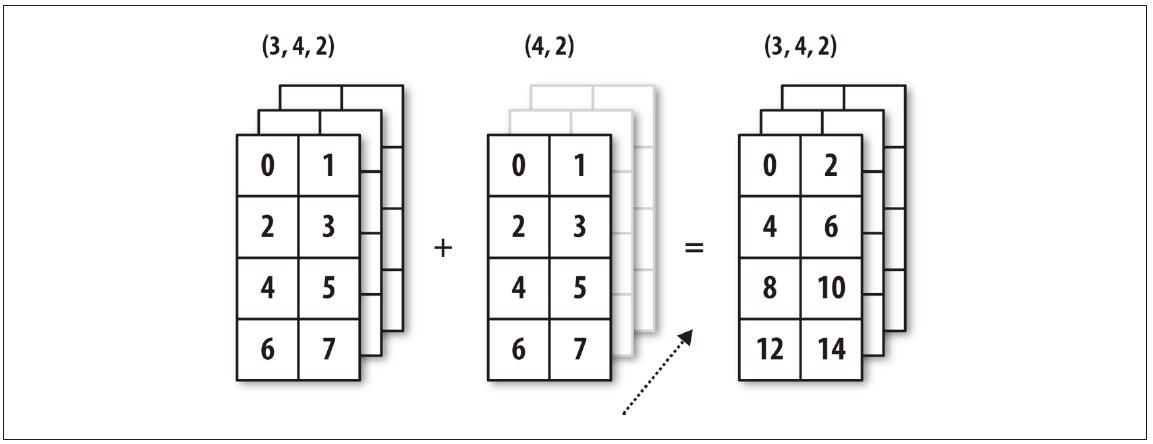

### A.3.1　在其他轴上广播
使用更高维度的数组进行广播可能会更加令人头痛，但这确实是遵循规则的问题。如果不这样做，会得到这样的错误：

In [58]:
arr - arr.mean(1)

ValueError: operands could not be broadcast together with shapes (4,3) (4,) 

想要在轴0以外的轴上使用较低维数组进行算术运算是相当普遍的。根据广播规则，**“广播维度”在较小的数组中必须为1**。在这里显示的行减均值的例子中，这表示重新塑造行意味着形状是`(4，1)`而不是`(4，)`：

In [61]:
arr - arr.mean(1).reshape((4, 1))

array([[-1.,  0.,  1.],
       [-1.,  0.,  1.],
       [-1.,  0.,  1.],
       [-1.,  0.,  1.]])

在三维情况下，在三个维度中的任何一个维度上进行广播只是将数据重塑为形状兼容的问题。下图显示了在三维数组的每个轴上广播所需的形状。

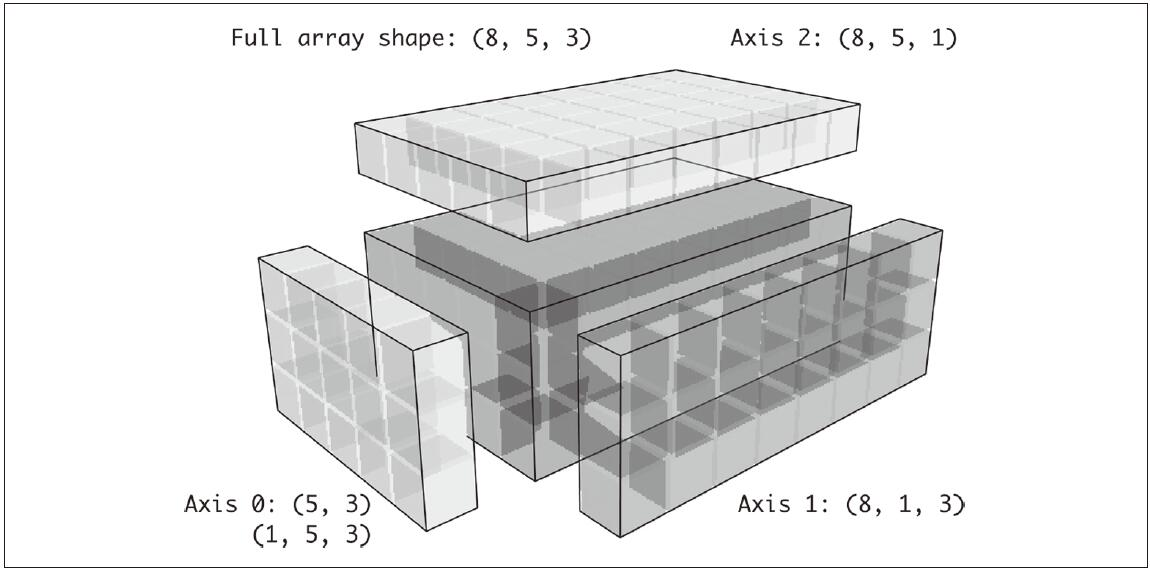

因此，一个常见的问题是需要添加一个长度为1的新轴，专门用于广播目的。使用`reshape`是一种选择，但插入一个轴需要构造一个表示新形状的元组。这通常是一个乏味的练习。因此，NumPy数组提供了一种通过索引插入新轴的特殊语法。使用特殊的`np.newaxis`属性和“完整”切片来插入新轴：

In [62]:
arr = np.ones((4, 4))

arr_3d = arr[:, np.newaxis, :]

arr_3d.shape

(4, 1, 4)

In [63]:
arr_1d = np.random.normal(size=3)
print(arr_1d.shape)

arr_1d[:, np.newaxis].shape

(3,)


(3, 1)

In [64]:
arr_1d[np.newaxis, :]

array([[ 1.18044185,  0.2963841 , -0.59557163]])

因此，如果有一个三维数组并想在轴2上减去均值，就需要这样写：

In [65]:
#arr = np.random.randn(3, 4, 5)
arr = np.arange(3*4*5).reshape((3,4,5))

depth_means = arr.mean(2)

depth_means

array([[ 2.,  7., 12., 17.],
       [22., 27., 32., 37.],
       [42., 47., 52., 57.]])

In [66]:
depth_means.shape

(3, 4)

In [67]:
demeaned = arr - depth_means[:, :, np.newaxis]

demeaned.mean(2)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

可能会想是否有一个在轴向上减均值但又不牺牲性能的方法。有的，但是它需要一些索引操作：

In [68]:
def demean_axis(arr, axis=0):
    means = arr.mean(axis)
    # 将形如[:, :, np.newaxis]的对象推广到N维
    indexer = [slice(None)] * arr.ndim
    indexer[axis] = np.newaxis
    return arr - means[indexer]

### A.3.2　通过广播设定数组的值
控制算术运算的相同广播规则也适用于通过数组索引设置值。在一个简单的例子中，可以做这样的事情：

In [69]:
arr = np.zeros((4, 3))

arr[:] = 5

arr

array([[5., 5., 5.],
       [5., 5., 5.],
       [5., 5., 5.],
       [5., 5., 5.]])

但是，如果想要将数值的一维数组设置到数组的列中，只要形状是兼容的就可以做到这一点：

In [70]:
col = np.array([1.28, -0.42, 0.44, 1.6])

arr[:] = col[:, np.newaxis]

arr

array([[ 1.28,  1.28,  1.28],
       [-0.42, -0.42, -0.42],
       [ 0.44,  0.44,  0.44],
       [ 1.6 ,  1.6 ,  1.6 ]])

In [71]:
arr[:2] = [[-1.37], [0.509]]

arr

array([[-1.37 , -1.37 , -1.37 ],
       [ 0.509,  0.509,  0.509],
       [ 0.44 ,  0.44 ,  0.44 ],
       [ 1.6  ,  1.6  ,  1.6  ]])

## A.4　高阶ufunc用法
虽然许多NumPy用户只会使用通用函数提供的按元素操作，但还有一些额外的功能偶尔可以帮助编写更简洁的代码而无须循环。

### A.4.1　ufunc实例方法
NumPy的每个二元ufunc（通用函数）都有特殊的方法来执行某些特殊的向量化操作。下表总结了这些内容，下面举几个具体示例来说明它们的工作原理。

| 方法 | 描述 |
| ---- | ---- |
| reduce(x) | 按操作的连续应用程序对数值聚合 |
| accumulate(x) | 聚合值，保留所有部分聚合 |
| reduceat(x, bins) | “本地”缩聚或“ group by”,<br>减少连续的数据切片以生成聚合数组 |
| outer(x,y) | 将操作应用于x和y中的所有元素对,<br>结果数组的形状为： x.shape + y.shape |

`reduce`方法接收单个数组并通过执行一系列二元操作在可选的轴向上对数组的值进行聚合。例如，使用`np.add.reduce`是对数组中元素进行加和的另一种方法：

In [72]:
arr = np.arange(10, 20)

np.add.reduce(arr)

145

In [73]:
arr.sum()

145

起始值（对于add方法是10）取决于`ufunc`。如果传递了一个轴，则沿该轴执行缩聚。这能够以简洁的方式回答某些种类的问题。作为一个不太重要的例子，可以使用`np.logical_and`来检查数组的每一行中的值是否被排序：

In [74]:
np.random.seed(12346)  # 为了可以复现

arr = np.random.randn(5, 5)

In [75]:
arr

array([[-8.99822478e-02,  7.59372617e-01,  7.48336101e-01,
        -9.81497953e-01,  3.65775545e-01],
       [-3.15442628e-01, -8.66135605e-01,  2.78568155e-02,
        -4.55597723e-01, -1.60189223e+00],
       [ 2.48256116e-01, -3.21536673e-01, -8.48730755e-01,
         4.60468309e-04, -5.46459347e-01],
       [ 2.53915229e-01,  1.93684246e+00, -7.99504902e-01,
        -5.69159281e-01,  4.89244731e-02],
       [-6.49092950e-01, -4.79535727e-01, -9.53521432e-01,
         1.42253882e+00,  1.75403128e-01]])

In [76]:
arr[::2].sort(1) # 对行排序

arr[:, :-1] < arr[:, 1:]

array([[ True,  True,  True,  True],
       [False,  True, False, False],
       [ True,  True,  True,  True],
       [ True, False,  True,  True],
       [ True,  True,  True,  True]])

In [77]:
# 按行求逻辑与（and）
np.logical_and.reduce(arr[:, :-1] < arr[:, 1:], axis=1)

array([ True, False,  True, False,  True])

> 请注意，`logical_and.reduce`等价于`all`方法。

`accumulate`与`reduce`是相关的，就像`cumsum`与`sum`相关一样。`accumulate`生成一个数组，其尺寸与中间“累计”值相同：

In [78]:
arr = np.arange(15).reshape((3, 5))

np.add.accumulate(arr, axis=1)

array([[ 0,  1,  3,  6, 10],
       [ 5, 11, 18, 26, 35],
       [10, 21, 33, 46, 60]])

In [79]:
# 和这个等价
arr.cumsum(axis=1)

array([[ 0,  1,  3,  6, 10],
       [ 5, 11, 18, 26, 35],
       [10, 21, 33, 46, 60]])

`outer`在两个数组之间执行成对的交叉乘积：

In [80]:
arr = np.arange(3).repeat([1, 2, 2])

arr

array([0, 1, 1, 2, 2])

In [81]:
np.multiply.outer(arr, np.arange(5))

array([[0, 0, 0, 0, 0],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 2, 4, 6, 8],
       [0, 2, 4, 6, 8]])

`outer`的输出的维度等于输入的维度总和：

In [82]:
x, y = np.random.randn(3, 4), np.random.randn(5)

result = np.subtract.outer(x, y)

result.shape

(3, 4, 5)

最后一个方法`reduceat`执行“本地缩聚”，本质上是一个数组`groupby`操作，在操作中数组的切片聚合在了一起。`reduceat`方法接受一系列的“箱体边缘”，这些箱体边缘表示如何分隔以及聚合数据值：

In [83]:
arr = np.arange(10)

# 在列表（[0,5,8]）的位置进行groupby，然后求和
np.add.reduceat(arr, [0, 5, 8])

array([10, 18, 17])

结果是在arr[0:5]、arr[5:8]和arr[8:]上执行了缩聚（此处是加和）。在其他方法中，可以传递一个`axis`参数：

In [84]:
arr = np.multiply.outer(np.arange(4), np.arange(5))

arr

array([[ 0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4],
       [ 0,  2,  4,  6,  8],
       [ 0,  3,  6,  9, 12]])

In [85]:
np.add.reduceat(arr, [0, 2, 4], axis=1)

array([[ 0,  0,  0],
       [ 1,  5,  4],
       [ 2, 10,  8],
       [ 3, 15, 12]])

表A-2列出了部分ufunc方法。

表A-2：ufunc方法


表A-2：ufunc方法（续）


### A.4.2　使用Python编写新的ufunc方法
有很多工具可以用于创建你自己的NumPy ufunc，最常用的是NumPy的C语言API，但是它已经超出了本书的范畴。纯Python的ufunc方法。

`numpy.frompyfunc`函数接收一个具有特定数字输入和输出的函数。例如，一个简单的按元素相加的函数可以如下：

In [86]:
def add_elements(x, y):
    return x + y

add_them = np.frompyfunc(add_elements, 2, 1)

add_them(np.arange(8), np.arange(3,11))

array([3, 5, 7, 9, 11, 13, 15, 17], dtype=object)

使用frompyfunc创建的函数通常返回的是Python对象的数组，这并不方便。幸运的是，还有另一个函数`numpy.vectorize`允许指定输出的类型（但功能稍差）：

In [87]:
add_them = np.vectorize(add_elements, otypes=[np.float64])

add_them(np.arange(8), np.arange(8))

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.])

这些函数提供了一种创建类似ufunc的函数的方法，但是它们非常慢，因为它们需要Python函数调用来计算每个元素，这比NumPy的基于C的ufunc循环要慢很多：

In [88]:
arr = np.random.randn(10000)

In [89]:
%timeit add_them(arr, arr)

3.48 ms ± 66.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
%timeit np.add(arr, arr)

11.2 µs ± 47.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


本章的后续内容会介绍如何使用Numba库（http://numba.pydata.org/ ）用Python语言创建快速ufunc。

## A.5　结构化和记录数组
到目前为止，你可能已经注意到，ndarray是一个同构数据的容器。也就是说，它表示一个内存块，其中每个元素占用相同数量的字节，由dtype确定。表面上，ndarray的这种特性不允许你使用它表示异构的数据或表格型数据。结构化数组是一个ndarray，其中每个元素可以被认为代表C中的struct（因此是“结构化”的名称），或者是SQL表中具有多个命名字段的行：

In [91]:
dtype = [('x', np.float64), ('y', np.int32)]

sarr = np.array([(1.5, 6), (np.pi, -2)], dtype=dtype)

sarr

array([(1.5       ,  6), (3.14159265, -2)],
      dtype=[('x', '<f8'), ('y', '<i4')])

有几种方法可以指定结构化的dtype（请参阅NumPy官方在线文档）。一种典型的方式是使用（field_name，field_data_type）作为元组的列表。现在，数组的元素是元组对象，其元素可以像字典一样访问：

In [92]:
sarr[0]

(1.5, 6)

In [93]:
sarr[0]['y']

6

字段名称存储在`dtype.names`属性中。当访问结构化数组中的字段时，将返回数据的分步视图，因此不会复制任何内容：

In [94]:
sarr['x']

array([1.5       , 3.14159265])

### A.5.1　嵌套dtype和多维字段
当指定结构化的dtype时，可以另外传递一个形状（以int或元组的形式）：

In [95]:
dtype = [('x', np.int64, 3), ('y', np.int32)]

arr = np.zeros(4, dtype=dtype)

arr

array([([0, 0, 0], 0), ([0, 0, 0], 0), ([0, 0, 0], 0), ([0, 0, 0], 0)],
      dtype=[('x', '<i8', (3,)), ('y', '<i4')])

在这种情况下，x字段引用的是每条记录中长度为3的数组：

In [96]:
arr[0]['x']

array([0, 0, 0])

很方便地，访问arr['x']然后返回一个二维数组，而不是像之前的例子那样返回一个一维数组：

In [97]:
arr['x']

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

这可以将更复杂的嵌套结构表示为数组中的单个内存块。也可以嵌套`dtype`来创建更复杂的结构。这里是一个例子：

In [98]:
dtype = [('x', [('a', 'f8'), ('b', 'f4')]), ('y', np.int32)]

data = np.array([((1, 2), 5), ((3, 4), 6)], dtype=dtype)

data

array([((1., 2.), 5), ((3., 4.), 6)],
      dtype=[('x', [('a', '<f8'), ('b', '<f4')]), ('y', '<i4')])

In [99]:
data['x']

array([(1., 2.), (3., 4.)], dtype=[('a', '<f8'), ('b', '<f4')])

In [100]:
data['y']

array([5, 6], dtype=int32)

In [101]:
data['x']['a']

array([1., 3.])

> pandas的DataFrame并不直接支持这个特性，尽管它与分层索引很相似。

### A.5.2　为什么要使用结构化数组
与pandas的DataFrame相比，NumPy结构化数组是一个相对底层的工具。结构化数组提供了一种将内存块解释为具有任意复杂嵌套列的表格结构的方法。由于数组中的每个元素都在内存中表示为固定数量的字节，因此结构化数组提供了读/写磁盘（包括内存映射）数据，以及在网络上传输数据和其他此类用途的非常快速有效的方法。

作为结构化数组的另一种常见用途，将数据文件编写为固定长度的记录字节流是将C和C++代码中的数据序列化的常用方法，这在业界传统系统中很常见。只要知道文件的格式（每个记录的大小以及每个元素的顺序、字节大小和数据类型），就可以用np.fromfile将数据读入内存。

## A.6　更多关于排序的内容
和Python的内建列表类似，ndarray的`sort`实例方法是一种原位排序，意味着数组的内容进行了重排列，而不是生成了一个新的数组：

In [102]:
arr = np.random.randn(6)
arr

array([ 1.13969136,  1.28881614,  0.37588273, -1.08199644,  1.84126094,
        0.80139193])

In [103]:
arr.sort()

arr

array([-1.08199644,  0.37588273,  0.80139193,  1.13969136,  1.28881614,
        1.84126094])

在进行数组原位排序时，请记住如果数组是不同ndarray的视图的话，原始数组将会被改变：

In [104]:
arr = np.random.randn(3, 5)

arr

array([[-0.33176812, -1.47108206,  0.87050269, -0.08468875, -1.13286962],
       [-1.01114869, -0.34357617,  2.17140268,  0.12337075, -0.01893118],
       [ 0.17731791,  0.7423957 ,  0.85475634,  1.03797268, -0.32899594]])

In [105]:
arr[:, 0].sort()  # 对第一列的值原位排序， 其他列不发生变化

arr

array([[-1.01114869, -1.47108206,  0.87050269, -0.08468875, -1.13286962],
       [-0.33176812, -0.34357617,  2.17140268,  0.12337075, -0.01893118],
       [ 0.17731791,  0.7423957 ,  0.85475634,  1.03797268, -0.32899594]])

另一方面，`numpy.sort`产生的是一个数组的新的、排序后的副本。否则，它接受与`ndarray.sort`相同的参数（如`kind`）：

In [106]:
arr = np.random.randn(5)

arr

array([-1.11807759, -0.24152521, -2.0051193 ,  0.73788753, -1.06137462])

In [107]:
arr1 = np.sort(arr)

print(arr,'\n', arr1)

[-1.11807759 -0.24152521 -2.0051193   0.73788753 -1.06137462] 
 [-2.0051193  -1.11807759 -1.06137462 -0.24152521  0.73788753]


所有这些排序方法都有一个`axis`参数，用于独立地沿着传递的轴对数据部分进行排序：

In [108]:
arr = np.random.randn(3, 5)

arr

array([[ 0.59545348, -0.26822958,  1.33885804, -0.18715572,  0.91108374],
       [-0.32150045,  1.00543901, -0.51683937,  1.19251887, -0.19893404],
       [ 0.39691349, -1.76381537,  0.60709023, -0.22215536, -0.21707838]])

In [109]:
arr.sort(axis=1)
arr

array([[-0.26822958, -0.18715572,  0.59545348,  0.91108374,  1.33885804],
       [-0.51683937, -0.32150045, -0.19893404,  1.00543901,  1.19251887],
       [-1.76381537, -0.22215536, -0.21707838,  0.39691349,  0.60709023]])

> 所有的排序方法都没有降序排列的选项。这是一个实践中的问题，因为数组切片会产生视图，因此不需要生成副本也不需要任何计算工作。很多Python用户对于列表（假设列表名为values）的一种"技巧"很熟悉，即`values[：：-1]`会返回一个反序的列表。对ndarray也是一样：

In [110]:
arr[:, ::-1]

array([[ 1.33885804,  0.91108374,  0.59545348, -0.18715572, -0.26822958],
       [ 1.19251887,  1.00543901, -0.19893404, -0.32150045, -0.51683937],
       [ 0.60709023,  0.39691349, -0.21707838, -0.22215536, -1.76381537]])

### A.6.1　间接排序：argsort和lexsort
在数据分析中，可能需要通过一个或多个键对数据集进行重新排序。例如，有关某些学生的数据表可能需要按姓氏排序，然后按名字排序。这是一个间接排序的例子。给定一个或多个键（一个或多个值的数组），希望获得一个整数索引（通称为`索引器`）数组，整数索引将告诉如何重新排列数据为指定顺序。两种实现该功能的方法是`argsort`和`numpy.lexsort`。举个例子：

In [111]:
values = np.array([5, 0, 1, 3, 2])

indexer = values.argsort()

# 排序后的index
indexer

array([1, 2, 4, 3, 0])

In [112]:
values[indexer]

array([0, 1, 2, 3, 5])

作为一个更复杂的例子，下面的代码对一个二维数组按照它的第一行进行重新排序：

In [113]:
arr = np.random.randn(3, 5)

arr[0] = values

arr

array([[ 5.        ,  0.        ,  1.        ,  3.        ,  2.        ],
       [-0.36360302, -0.13775933,  2.17773731, -0.47280687,  0.8356152 ],
       [-0.20885016,  0.23159352,  0.72798172, -1.3918432 ,  1.99558262]])

In [114]:
# 按第一列进行排序
arr[:, arr[0].argsort()]

array([[ 0.        ,  1.        ,  2.        ,  3.        ,  5.        ],
       [-0.13775933,  2.17773731,  0.8356152 , -0.47280687, -0.36360302],
       [ 0.23159352,  0.72798172,  1.99558262, -1.3918432 , -0.20885016]])

`lexsort`类似于`argsort`，但它对多键数组执行间接字典排序。假设想对一些由名字和姓氏标识的数据进行排序：

In [115]:
first_name = np.array(['Bob', 'Jane', 'Steve', 'Bill', 'Barbara'])

last_name = np.array(['Jones', 'Arnold', 'Arnold', 'Jones', 'Walters'])

sorter = np.lexsort((first_name, last_name))

sorter

array([1, 2, 3, 0, 4])

In [116]:
name = zip(last_name[sorter], first_name[sorter])

In [117]:
for i in name:
    print(i)

('Arnold', 'Jane')
('Arnold', 'Steve')
('Jones', 'Bill')
('Jones', 'Bob')
('Walters', 'Barbara')


在第一次使用`lexsort`时，`lexsort`可能有点令人困惑，因为用于排序数据的键的顺序从传递的**最后一个数组**开始(`逆序`)。这里，last_name在first_name之前使用。

> pandas的方法，比如Series和DataFrame的`sort_values`方法是对这些方法的变相实现（这些方法必须要考虑缺失值）。

### A.6.2　其他的排序算法
稳定排序算法保留了相等元素的相对位置。在相对顺序有意义的间接排序中，这可能尤其重要：

In [118]:
values = np.array(['2:first', '2:second', '1:first', '1:second',
                   '1:third'])

key = np.array([2, 2, 1, 1, 1])

indexer = key.argsort(kind='mergesort')

indexer

array([2, 3, 4, 0, 1])

In [119]:
values.take(indexer)

array(['1:first', '1:second', '1:third', '2:first', '2:second'],
      dtype='<U8')

唯一可用的稳定排序是`mergesort`，它保证了`O(n log n)`性能（对于复杂性增益），但其平均性能比默认的`quicksort`方法更差。请参阅下表，了解可用方法及其相对性能（和性能保证）的总结。

| 种类 | 速度 | 是否稳定 | 工作空间 | 最差情况 |
| --- | --- | ------- | ------- | ------- |
| quicksort | 1 | No | 0 | O(n^2) |
| mergesort | 2 | Yes | n/2 | O(n log n) |
| heapsort | 3 | No | 0 | O(n log n) |

### A.6.3　数组的部分排序
排序的目标之一可以是确定数组中最大或最小的元素。NumPy已经优化了方法`numpy.partition`和`np.argpartition`，用于围绕第k个最小元素对数组进行分区：

In [120]:
np.random.seed(12345)

arr = np.random.randn(20)

arr

array([-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057,
        1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474,
        1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684,
        0.88642934, -2.00163731, -0.37184254,  1.66902531, -0.43856974])

In [121]:
np.partition(arr, 3)

array([-2.00163731, -1.29622111, -0.5557303 , -0.51943872, -0.37184254,
       -0.43856974, -0.20470766,  0.28174615,  0.76902257,  0.47894334,
        1.00718936,  0.09290788,  0.27499163,  0.22891288,  1.35291684,
        0.88642934,  1.39340583,  1.96578057,  1.66902531,  1.24643474])

在调用`partition(arr，3)`之后，结果中的前三个元素是最小的三个值，并不是特定的顺序。`numpy.argpartition`类似于`numpy.argsort`排序，它返回的是将数据重新排列为等价顺序的索引：

In [122]:
indices = np.argpartition(arr, 3)

indices

array([16, 11,  3,  2, 17, 19,  0,  7,  8,  1, 10,  6, 12, 13, 14, 15,  5,
        4, 18,  9])

In [123]:
arr.take(indices)

array([-2.00163731, -1.29622111, -0.5557303 , -0.51943872, -0.37184254,
       -0.43856974, -0.20470766,  0.28174615,  0.76902257,  0.47894334,
        1.00718936,  0.09290788,  0.27499163,  0.22891288,  1.35291684,
        0.88642934,  1.39340583,  1.96578057,  1.66902531,  1.24643474])

### A.6.4　`numpy.searchsorted`：在已排序的数组寻找元素
`searchsorted`是一个数组方法，它对已排序数组执行二分搜索，返回数组中需要插入值的位置以保持排序：

In [124]:
arr = np.array([0, 1, 7, 12, 15])

arr.searchsorted(9)

3

可以传递一个值数组来获取一个索引数组：

In [125]:
arr.searchsorted([0, 8, 11, 16])

array([0, 3, 3, 5])

> 对于0元素，`searchsorted`返回0。这是因为默认行为是返回一组相等值`左侧`的索引：

In [126]:
arr = np.array([0, 0, 0, 1, 1, 1, 1])

arr.searchsorted([0, 1])

array([0, 3])

In [127]:
arr.searchsorted([0, 1], side='right')

array([3, 7])

作为`searchsorted`的另一个应用，假设有一个介于0和10,000之间的数值，以及想用来分隔数据的单独的“桶边界”数组：

In [128]:
data = np.floor(np.random.uniform(0, 10000, size=50))

bins = np.array([0, 100, 1000, 5000, 10000])

data

array([9940., 6768., 7908., 1709.,  268., 8003., 9037.,  246., 4917.,
       5262., 5963.,  519., 8950., 7282., 8183., 5002., 8101.,  959.,
       2189., 2587., 4681., 4593., 7095., 1780., 5314., 1677., 7688.,
       9281., 6094., 1501., 4896., 3773., 8486., 9110., 3838., 3154.,
       5683., 1878., 1258., 6875., 7996., 5735., 9732., 6340., 8884.,
       4954., 3516., 7142., 5039., 2256.])

然后得到每个数据点属于哪个区间的标签（其中`1`代表桶`[0，100)`），可以简单地使用`searchsorted`：

In [129]:
labels = bins.searchsorted(data)

labels

array([4, 4, 4, 3, 2, 4, 4, 2, 3, 4, 4, 2, 4, 4, 4, 4, 4, 2, 3, 3, 3, 3,
       4, 3, 4, 3, 4, 4, 4, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4,
       4, 3, 3, 4, 4, 3])

可以和pandas的`groupby`一起被用于分箱数据：

In [130]:
pd.Series(data).groupby(labels).mean()

2     498.000000
3    3064.277778
4    7389.035714
dtype: float64

## A.7　使用Numba编写快速NumPy函数
Numba（http://numba.pydata.org ）是一个开源项目，可为使用CPU、GPU或其他硬件的NumPy类型的数据创建快速函数。它使用LLVM Project（http://llvm.org ）将Python代码翻译成编译后的机器码。

为了介绍Numba，首先考虑一个纯Python函数，该函数使用for循环计算表达式`(x-y).mean()`的值：

In [131]:
import numpy as np
def mean_distance(x, y):
    nx = len(x)
    result = 0.0
    count = 0
    for i in range(nx):
        result += x[i] - y[i]
        count += 1
    return result / count

这个函数是非常慢的：

In [132]:
x = np.random.randn(10000000)

y = np.random.randn(10000000)

In [133]:
%timeit mean_distance(x, y)

9.52 s ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [134]:
%timeit (x - y).mean()

87.4 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NumPy的版本要快100倍。可以使用`numba.jit`函数将这个函数编译成Numba函数：

In [135]:
import numba as nb

numba_mean_distance = nb.jit(mean_distance)

也可以写成装饰器的形式：

In [136]:
@nb.jit
def mean_distance(x, y):
    nx = len(x)
    result = 0.0
    count = 0
    for i in range(nx):
        result += x[i] - y[i]
        count += 1
    return result / count

结果函数实际上比矢量化的NumPy版本更快：

In [137]:
%timeit numba_mean_distance(x, y)

33.1 ms ± 342 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [138]:
%timeit mean_distance(x, y)

33.2 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Numba不能编译所有的Python代码，但它支持纯Python代码的重要子集，这些代码对于编写数值算法最为有用。

Numba是一个有深度的类库，支持各种不同的硬件、兼容模式和用户拓展。它还可以在不显式使用for循环的情况下兼容NumPy的Python API。Numba能够识别可以编译为机器代码的构造，同时将不知道如何编译的函数的调用替换为CPython API。Numba的`jit`函数有一个选项，`nopython=True`，它将允许的代码限制为可以编译为LLVM的Python代码，而无须调用任何Python的C语言API。`jit(nopython=True)`有一个更短的别名`numba.njit`。

在之前的例子中，可以写为：

In [139]:
from numba import float64, njit

@njit(float64(float64[:], float64[:]))
def mean_distance(x, y):
    return (x - y).mean()

In [140]:
%timeit mean_distance(x, y)

140 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


推荐通过阅读Numba的官方在线文档（http://numba.pydata.org ）来学习更多内容。下一节将会展示一个创建自定义NumPy ufunc对象的例子。

### A.7.1　使用Numba创建自定义numpy.ufunc对象
`numba.vectorize`函数创建了编译好的NumPy ufunc，其行为也和内建的ufunc类似。让考虑一个`numpy.add`的Python实现：

In [141]:
from numba import vectorize

@vectorize
def nb_add(x, y):
    return x + y

然后可以得到：

In [142]:
x = np.arange(10)

nb_add(x, x)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [143]:
nb_add.accumulate(x, 0)

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])

## A.8　高阶数组输入和输出
在第4章中熟悉`np.save`和`np.load`，它们用于在磁盘上以二进制格式存储数组。对于更复杂的使用，还有许多其他选项需要考虑。特别是，内存映射有额外的好处，允许处理不适合进入内存的数据集。

### A.8.1　内存映射文件
内存映射文件是一种与磁盘上的二进制数据交互的方法，就像它是存储在内存数组中一样。NumPy实现了一个`memmap`对象，它是ndarray型的，允许对大型文件以小堆栈的方式进行读取和写入，而无须将整个数组载入内存。此外，memmap还有和内存数组相同的方法，因此可以替代很多算法中原本要填入的ndarray。

要创建一个新的内存映射，使用`np.memmap`并传入文件路径、dtype、shape和文件模式：

In [144]:
mmap = np.memmap('mymmap', dtype='float64', mode='w+',
                 shape=(100, 100))

mmap

memmap([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

对`memmap`切片返回的是硬盘上数据的视图：

In [145]:
section = mmap[:5]

如果将数据赋值给这些切片，它将会在内存中缓冲（类似于一个Python文件对象），可以调用`flush`将数据写入硬盘：

In [146]:
section[:] = np.random.randn(5, 100)

mmap.flush()

mmap

memmap([[ 1.37140985,  0.93127837,  0.60573747, ..., -0.09308486,
          0.37927188, -0.0506558 ],
        [-0.95178716,  0.32836534, -1.93090657, ..., -0.64631054,
          1.29561034,  0.60977587],
        [ 0.44088058, -1.67795611,  1.84960161, ..., -0.61811136,
         -0.06253954,  1.02085572],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [147]:
del mmap

每当内存映射超出范围并且被垃圾收集时，任何更改都将刷新到磁盘。打开已经存在的内存映射时，仍然必须指定dtype和shape，因为该文件只是磁盘上没有元数据的二进制数据块：

In [148]:
mmap = np.memmap('mymmap', dtype='float64', shape=(100, 100))

mmap

memmap([[ 1.37140985,  0.93127837,  0.60573747, ..., -0.09308486,
          0.37927188, -0.0506558 ],
        [-0.95178716,  0.32836534, -1.93090657, ..., -0.64631054,
          1.29561034,  0.60977587],
        [ 0.44088058, -1.67795611,  1.84960161, ..., -0.61811136,
         -0.06253954,  1.02085572],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

内存映射也适用于结构化或嵌套的dtype，如前一节所述。

### A.8.2　HDF5和其他数组存储选择
PyTables和h5py是两个为NumPy提供友好接口的Python项目，用于以高效和可压缩的HDF5格式存储数组数据（HDF代表分层数据格式，Hierarchical Data Format）。

可以安全地以HDF5格式存储数百GB或甚至上TB的数据。要了解有关在Python中使用HDF5的更多信息，建议阅读pandas官方在线文档（http://pandas.pydata.org ）。

## A.9　性能技巧
利用NumPy从代码中获得良好性能通常很简单，因为数组操作通常会取代相对缓慢的纯Python循环。以下列表简要总结了一些需要注意的事项：

* 将Python循环和条件逻辑转换为数组操作和布尔数组操作

* 尽可能使用广播

* 使用数组视图（切片）来避免复制数据

* 使用`ufunc`和`ufunc`方法

如果在用尽NumPy提供的功能之后仍然无法获得所需的性能，请考虑在C、Fortran或Cython中编写代码。在工作中经常会使用Cython进行一些微小开发，这是一种获得近乎C语言性能的方式。

### A.9.1　连续内存的重要性
尽管本主题的完整内容超出了本书的范围，但在某些应用中，数组的内存布局会显著影响计算速度。这种情况是基于CPU的缓存层次结构相关的性能差异。访问连续内存块的操作（例如，将C顺序数组的行相加）通常是最快的，因为存储器子系统会将适当的存储器块缓冲到超快的L1或L2CPU缓存中。此外，NumPy的C代码库中的某些代码路径已进行优化，在连续内存的情况下可以避免对通用跨步内存的访问。

如果说数组的内存布局是连续的，就意味着这些元素按照它们在Fortran顺序（列方向）或C顺序（行方向）排序中出现在数组中的次序存储在内存中。默认情况下，NumPy数组创建为C顺序连续或只是简单连续。因此，一个列方向的数组，例如C顺序数组的转置数组，可以称为是Fotran顺序连续的。这些属性都是可以通过ndarray的flags属性来检查的：

In [149]:
arr_c = np.ones((1000, 1000), order='C')

arr_f = np.ones((1000, 1000), order='F')

arr_c.flags    

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [150]:
arr_f.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [151]:
arr_f.flags.f_contiguous

True

在这个例子中，对这些数组的行及逆行加和，在理论上arr_c是比arr_f更快，这是因为arr_c的行在内存中是连续的。这里使用IPython中的`%timeit`进行检查：

In [152]:
%timeit arr_c.sum(1)

1.13 ms ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [153]:
%timeit arr_f.sum(1)

1.79 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


当想从NumPy中挤出更多的性能时，往往需要投入一些努力。如果数组没有所需的内存顺序，则可以使用`copy`并传递'C'或'F'：

In [154]:
arr_f.copy('C').flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

在数组上构建视图时，请记住结果并不能保证是连续的：

In [155]:
arr_c[:50].flags.contiguous

True

In [156]:
arr_c[:, :50].flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

> 一些dtype的名字后面有下划线。这些是为了避免NumPy特定类型和Python内置类型之间的变量名称冲突。